# Convnet Fundamental Operations

## Single Channel Convolution (e.g. gray scale image)

- For this purpose, convolution for a matrix A with a kernel K is defined as `dot_product(reverse(A),K)`.
- See http://stackoverflow.com/questions/20036663 for details.
- Example:

```
A = [[1,1],
     [0,0]]
     
K = [[0,0],
     [0,1]]
     
A*K = dot_product(reverse(A), K) 
    = dot_product(reverse([1,1,0,0]), K) 
    = dot_product([0,0,1,1], K)
    = 0*0 + 0*0 + 0*1 + 1*1 
    = 1
```

Using Theano backend.


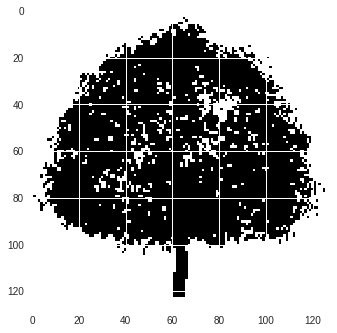

Window shape: (1, 4, 4)
Window values:
 [[[ 1.  1.  1.  1.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  0.]
  [ 1.  0.  0.  0.]]]


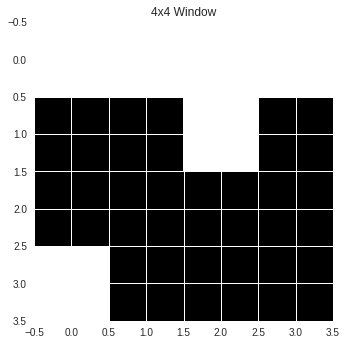

--------------------------------------------------
Kernel shape: (1, 1, 2, 2)
Kernel weights:
 [[[[ 0.  0.]
   [ 0.  1.]]]]
--------------------------------------------------
Convolution output shape: (1, 1, 2, 2)
Convolution output values:
 [[[[ 1.  1.]
   [ 0.  0.]]]]


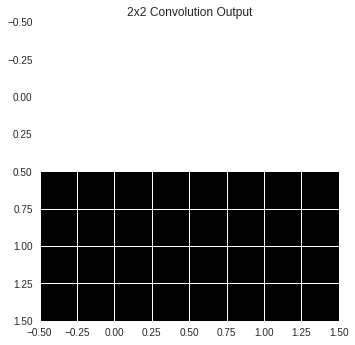

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.misc import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, BatchNormalization, Activation, Reshape
import keras.backend as K

# Theano dimension ordering is better for printing with numpy,
# though it requires transposing images before inputing to network.
K.set_image_dim_ordering('th')

np.random.seed(11)

# Read image and convert it to a grayscale binary mask.
img = imread('./tree.jpg')
img_g = rgb2gray(img).round()
plt.imshow(img_g, cmap='gray')
plt.show()

# Cut out a small window of the image.
# Keras requires the individual values to be 1x1 arrays.
wdw = img_g[90:94,90:94].reshape(4,4,1).transpose([2,0,1])
print('Window shape:', wdw.shape)
print('Window values:\n', wdw)
plt.title('4x4 Window')
plt.imshow(wdw.reshape(4,4), cmap='gray')
plt.show()
print('-'*50)

# 1x2x2 Convolution over the window with no bias.
# 1 feature channel, 2x2 kernel.
# Give it some simple weights.
kernel = np.random.rand(1,1,2,2).round()
weights = [kernel]
model = Sequential([
    Convolution2D(1,2,2,subsample=(2,2), input_shape=wdw.shape, bias=False, weights=weights)
])
model.compile(loss='mse', optimizer='sgd')

print('Kernel shape:', model.layers[0].get_weights()[0].shape)
print('Kernel weights:\n', model.layers[0].get_weights()[0])
print('-'*50)

# Apply the convolution to the window.
# Again, for matrices A and B, convolution is defined as dot_product(reverse(A), B).
# It should be possible to piece this together from the printed matrices.
output = model.predict(np.array([wdw]))
print('Convolution output shape:', output.shape)
print('Convolution output values:\n', output)
plt.title('2x2 Convolution Output')
plt.imshow(output.reshape(2,2), cmap='gray')
plt.show()

## Multi-Channel Convolution (e.g. RGB Image)

- The kernel now has a channel corresponding to each of the image channels.
- Single-channel convolution is done for each of the channels with its corresponding kernel channel.
- Then the results are added up.
- Example:

```
A = [[119 143]    # Channel 0
     [66  100]]
    [[146 172]    # Channel 1
     [91  126]]
    [[115 141]    # Channel 2
     [62  97]]

K = [[0   1]      # Channel 0
     [0   1]]
    [[0   0]      # Channel 1
     [0   1]]
    [[0   0]      # Channel 2
     [1   0]]
     
A*K = sum(dot_product(reverse([119 143 66 100]), [0 1 0 1]),
          dot_product(reverse([146 172 91 126]), [0 0 0 1]),
          dot_product(reverse([115 141 62 97 ]), [0 0 1 0]))
    = sum(sum(66, 119), sum(146), sum(141))
    = 66 + 119 + 146 + 141
    = 472
```

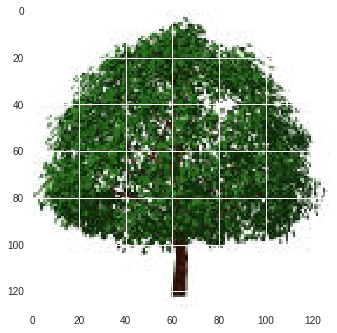

Image shape: (128, 128, 3)
--------------------------------------------------
Window shape: (3, 4, 4)
Window values:
 [[[119 143 119 119]
  [ 66 100 236  92]
  [ 63  28  99  50]
  [189  51  48  69]]

 [[146 172 150 149]
  [ 91 126 255 119]
  [ 88  50 121  73]
  [212  70  65  88]]

 [[115 141 116 113]
  [ 62  97 233  88]
  [ 59  27  98  47]
  [186  50  47  66]]]


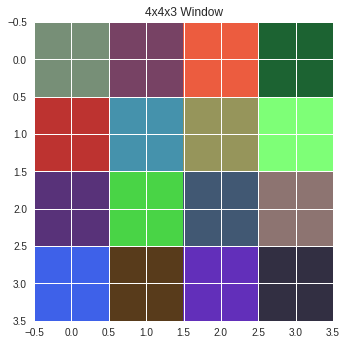

--------------------------------------------------
Kernel weights shape: (1, 3, 2, 2)
Kernel weights:
 [[[[ 0.  0.]
   [ 0.  1.]]

  [[ 0.  0.]
   [ 0.  1.]]

  [[ 0.  0.]
   [ 0.  1.]]]]
--------------------------------------------------
Convolution output:
 [[[[ 380.  385.]
   [ 210.  318.]]]]


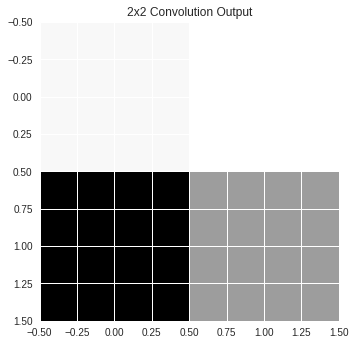

In [2]:
np.random.seed(11)
        
img = imread('./tree.jpg')
plt.imshow(img)
plt.show()

print('Image shape:', img.shape)
print('-'*50)

wdw = img[90:94,90:94,:].transpose([2,0,1])
print('Window shape:', wdw.shape)
print('Window values:\n', wdw)
plt.title('4x4x3 Window')
plt.imshow(wdw.reshape(4,4,3), cmap='gray')
plt.show()
print('-'*50)

kernel = np.random.rand(1,2,2).round()
kernels = np.array([kernel,kernel,kernel]).reshape(1,3,2,2)
weights = [kernels]
model = Sequential([
    Convolution2D(1,2,2,input_shape=wdw.shape,bias=False,weights=weights,subsample=(2,2))
])
model.compile(loss='mse',optimizer='sgd')

w = model.layers[0].get_weights()[0]
print('Kernel weights shape:', w.shape)
print('Kernel weights:\n', w)
print('-'*50)

output = model.predict(np.array([wdw]))
print('Convolution output:\n', output)
plt.title('2x2 Convolution Output')
plt.imshow(output.reshape(2,2), cmap='gray')
plt.show()

## 1 x 1 Convolutions

- My understanding is that 1x1 convolutions are useful for reducing filter dimensionality.
- For example, when you have a convolution layer with multiple filters, you can use a 1x1 convolution to reduce each filter's output to a single value.
- The 1x1 convolution layer can still output multiple filters itself. It's just a matter of each of its kernels producing a single value.
- Explanations: http://stats.stackexchange.com/questions/194142/

In [3]:
img = imread('./tree.jpg')
wdw = img[90:94,90:94,:].transpose([2,0,1])

# Layer 1 takes the window and creates 2 filters using (2x2) kernels.
layer_1 = Sequential([
    Convolution2D(2,2,2,input_shape=wdw.shape,subsample=(2,2))
])
layer_1.compile(loss='mse', optimizer='sgd')
layer_1.summary()

# Layer 2 compresses each of the 2 filters to a single value. 
# It produces two filters of its own from these values.
layer_2 = Sequential([
    Convolution2D(2,1,1,bias=False,subsample=(2,2),input_shape=layer_1.output_shape[1:])
])
layer_2.compile(loss='mse', optimizer='sgd')
layer_2.summary()
print('-'*50)

output_1 = layer_1.predict(np.array([wdw]))
print('Layer 1 output shape:', output_1.shape)

output_2 = layer_2.predict(output_1)
print('Layer 2 output shape:', output_2.shape)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 2, 2, 2)       26          convolution2d_input_3[0][0]      
Total params: 26
Trainable params: 26
Non-trainable params: 0
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 2, 1, 1)       4           convolution2d_input_4[0][0]      
Total params: 4
Trainable params: 4
Non-trainable params: 0
____________________________________________________________________________________________________
--------------------------------------------------
Layer 1 output shap

## (Max) Pooling

- A pooling layer considers windows from its inputs and compresses the window down to a single value (e.g. the max from the window).
- Example:

```
Max pooling over 2x2x3 section:

[[119 143 ...]
 [66  100 ...]]
[[146 172 ...]
 [91  126 ...]]
[[115 141 ...]
 [62  97  ...]]
 
Yields the output:

[[143 ...]]
[[172 ...]]
[[141 ...]]

```

In [4]:
img = imread('./tree.jpg')
wdw = img[90:94,90:94].transpose([2,0,1])

print('Window values:\n', wdw)
print('-'*50)
model = Sequential([
    MaxPooling2D(pool_size=(2,2), input_shape=wdw.shape, strides=(2,2))
])
model.compile(loss='mse', optimizer='sgd')

output = model.predict(np.array([wdw]))
print('Max pooling output shape:', output.shape)
print('Max pooling output:\n', output)

Window values:
 [[[119 143 119 119]
  [ 66 100 236  92]
  [ 63  28  99  50]
  [189  51  48  69]]

 [[146 172 150 149]
  [ 91 126 255 119]
  [ 88  50 121  73]
  [212  70  65  88]]

 [[115 141 116 113]
  [ 62  97 233  88]
  [ 59  27  98  47]
  [186  50  47  66]]]
--------------------------------------------------
Max pooling output shape: (1, 3, 2, 2)
Max pooling output:
 [[[[ 143.  236.]
   [ 189.   99.]]

  [[ 172.  255.]
   [ 212.  121.]]

  [[ 141.  233.]
   [ 186.   98.]]]]


## Batch Normalization

- A lot of Kaggle solutions and other deep learning discussions on the interwebs suggest using Batch Normalization as a silver bullet for improving performance, but what is it doing and why does it improve performance?
- Original paper: https://arxiv.org/pdf/1502.03167v2.pdf
- More discussion about the paper: https://www.reddit.com/r/MachineLearning/comments/2x0bq8
- Concise explanation according to http://stackoverflow.com/questions/34716454:

> The general use case is to use BN between the linear and non-linear layers in your network, because it normalizes the input to your activation function, so that you're centered in the linear sectio of the activation function (such as Sigmoid).

- In the example below it's interesting that the loss never decreases for the batch normalized version, but there certainly is a difference in the output distributions.

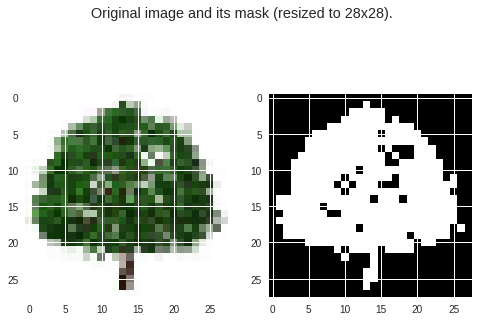

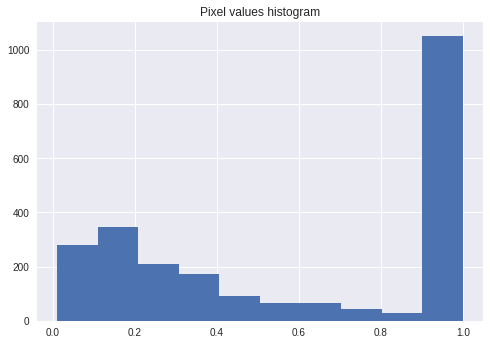

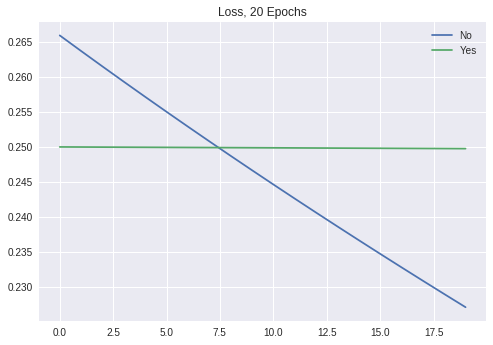

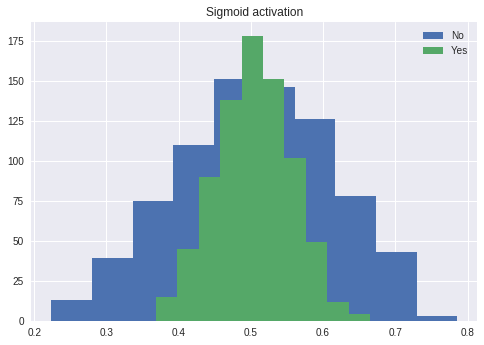

In [9]:
img = resize(imread('./tree.jpg'), (28,28)).transpose([2,0,1])
msk = resize(rgb2gray(imread('./tree.jpg')), (28,28)).round()
X, Y = np.array([img]*500), np.array([msk]*500)

fig,_ = plt.subplots(nrows=1,ncols=2)
fig.axes[0].imshow(img.transpose([1,2,0]))
fig.axes[1].imshow(msk)
fig.suptitle('Original image and its mask (resized to 28x28).')
plt.show()

plt.title('Pixel values histogram')
plt.hist(img.reshape(img.size))
plt.show()

nb_epoch = 20

# Sigmoid output without batch normalization.
np.random.seed(11)
model_n = Sequential([
    Reshape(input_shape=img.shape, target_shape=(img.size,)),
    Dense(500, activation='sigmoid'),
    Dense(msk.size, activation='sigmoid'),
    Reshape(target_shape=msk.shape)
])
model_n.compile(loss='mse', optimizer='sgd')
result_n = model_n.fit(X,Y,nb_epoch=nb_epoch,verbose=0)
output_n = model_n.predict(np.array([img]))

# Sigmoid output with batch normalization.
np.random.seed(11)
model_y = Sequential([
    Reshape(input_shape=img.shape, target_shape=(img.size,)),
    Dense(500, activation='linear'),
    BatchNormalization(),
    Activation('sigmoid'),
    Dense(msk.size, activation='linear'),
    BatchNormalization(),
    Activation('sigmoid'),
    Reshape(target_shape=msk.shape)
])
model_y.compile(loss='mse', optimizer='sgd')
result_y = model_y.fit(X,Y,nb_epoch=nb_epoch,verbose=0)
output_y = model_y.predict(np.array([img]))

plt.title('Loss, %d Epochs' % nb_epoch)
plt.plot(result_n.history['loss'], label='No')
plt.plot(result_y.history['loss'], label='Yes')
plt.legend()
plt.show()

plt.title('Sigmoid activation')
plt.hist(output_n.reshape(output_n.size), label='No')
plt.hist(output_y.reshape(output_y.size), label='Yes')
plt.legend()
plt.show()

## Merging Layers

- Some of the more sophisticated network implementations (e.g. UNet Ronneberger et.al., FCNN Long et.al.) merge the output from early layers into later layers.